In [1]:
import glob
import os
import numba 
import numpy as np
import pandas as pd
import scipy.signal

# Image processing tools
import skimage
import skimage.io

import bebi103

import matplotlib.pyplot as plt
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)
%matplotlib inline

# Import Bokeh modules for interactive plotting
import bokeh
bokeh.io.output_notebook()

Loading BokehJS ...

Overview of what we are doing:
1. Get normalized intensity vs. time plots for all eight jellyfish for both day and night time
2. Get number of times each jellyfish "pulses" in timeframes from start to finish
   - We chose to use 160 frames (10.666666 seconds) per interval (thus, each 4000 frame clip would return a 25 number list representing number of pulses in each interval of 160 frames.
   - We wrote a function to obtain number of pulses in a timeframe. The docstring and comments of function (below) go through how it works
3. Use HackerStats to compare mean number of pulses per 10.666666 second interval between same jellyfish of different time periods (night vs. day).
4. Compute mean estimates and confidence intervals for number of pulses per time interval.
5. Compute p-values assuming that the number of pulses for intervals for the same jellyfish for both day and night come from the same distribution.

In [2]:
def pulsePerInterval(arr):
    ''' Takes a numpy array of data points of pixel density and 
    creates a list with an element for each ~10.6 seconds interval, 
    whose value is the number of pulses in that interval. '''
    
    result = []
    m = np.percentile(arr, 25) 
    # Our threshold is the 25th percentile. We thought this would be a reasonable threshold as
    # this would represent the "contraction phase" of the pulse which would represnt a pulse
    
    for i in range(len(arr) - 1):
        # There are 266.7 seconds of footage in each file. 266.7 s / 10.6 s = 25 intervals.
        # 4000 pts / 25 intervals = 160 pts per interval
        if i % 160 == 0:
            result.append(0)
            
        # If the data curve crosses the threshold, we add to the interval we're currently on.
        if (arr[i + 1] > m and arr[i] < m) or (arr[i + 1] < m and arr[i] > m):
            result[-1] += 1
            
            
            
    # We divide by 2 because the number of roots is twice the number of wavelengths, which
    # is the number of pulses.
    return np.array(result) / 2

Now, let's get some HackerStats functions from last week to help us interpret data. 

In [3]:
@numba.jit(nopython=True)
def draw_bs_sample(data):
    """
    Draw a bootstrap sample from a 1D data set.
    """
    return np.random.choice(data, size=len(data))

In [4]:
def draw_bs_reps(data, stat_fun, size=10000):
    """
    Draw boostrap replicates computed with stat_fun from 1D data set.
    """
    return np.array([stat_fun(draw_bs_sample(data)) for _ in range(size)])


@numba.jit(nopython=True)
def draw_bs_reps_mean(data, size=10000):
    """
    Draw boostrap replicates of the mean from 1D data set.
    """
    out = np.empty(size)
    for i in range(size):
        out[i] = np.mean(draw_bs_sample(data))
    return out


@numba.jit(nopython=True)
def draw_bs_reps_median(data, size=10000):
    """
    Draw boostrap replicates of the median from 1D data set.
    """
    out = np.empty(size)
    for i in range(size):
        out[i] = np.median(draw_bs_sample(data))
    return out

@numba.jit(nopython=True)
def draw_bs_reps_std(data, size=10000):
    """
    Draw boostrap replicates of the standard deviation from 1D data set.
    """
    out = np.empty(size)
    for i in range(size):
        out[i] = np.std(draw_bs_sample(data))
    return out
@numba.jit#(nopython=True)
def draw_perm_sample(x, y):
    '''Generate a permutation sample.'''
    concat_data = np.concatenate((x, y))
    np.random.shuffle(concat_data)
    return concat_data[:len(x)], concat_data[len(x):]

@numba.jit#(nopython=True)
def draw_perm_reps_diff_mean(x, y, size=10000):
    '''
    Generate array of permuation replicates.
    '''
    out = np.empty(size)
    for i in range(size):
        x_perm, y_perm = draw_perm_sample(x, y)
        out[i] = abs(np.mean(x_perm) - np.mean(y_perm))
    return out

In [5]:
# The directory containing daytime data
data_dir = '../data/Cassiopea_Pulsation/day'

# Glob string for images
im_glob = os.path.join(data_dir, '*.TIF')

# Get list of files in directory
im_list = glob.glob(im_glob)

# Let's look at the first 10 entries
im_list[:10]

['../data/Cassiopea_Pulsation/day\\Frame_545000.TIF',
 '../data/Cassiopea_Pulsation/day\\Frame_545001.TIF',
 '../data/Cassiopea_Pulsation/day\\Frame_545002.TIF',
 '../data/Cassiopea_Pulsation/day\\Frame_545003.TIF',
 '../data/Cassiopea_Pulsation/day\\Frame_545004.TIF',
 '../data/Cassiopea_Pulsation/day\\Frame_545005.TIF',
 '../data/Cassiopea_Pulsation/day\\Frame_545006.TIF',
 '../data/Cassiopea_Pulsation/day\\Frame_545007.TIF',
 '../data/Cassiopea_Pulsation/day\\Frame_545008.TIF',
 '../data/Cassiopea_Pulsation/day\\Frame_545009.TIF']

In [6]:
im = skimage.io.imread(im_list[0])

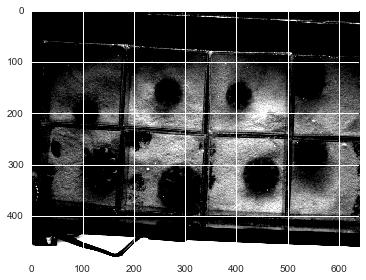

In [7]:
im = im[:,:,0]
skimage.io.imshow(im);

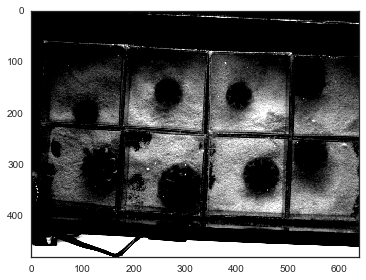

In [8]:
with sns.axes_style('white'):
    skimage.io.imshow(im)

In [9]:
# Jellyfish 1
verts = [(26.735349615665427, 58.274273045821303), (25.489542592753367, 211.5085368640049), (174.98638534220078, 225.21241411603756), (186.19864854840932, 65.749115183293668)]

In [10]:
ic = skimage.io.ImageCollection(im_glob, conserve_memory=True)
len(ic)

4000

In [11]:
def squish_rgb(fname, **kwargs):
    """
    Only take one channel. (Need to explicitly have the **kwargs to play
    nicely with skimage.io.ImageCollection.)
    """
    im = skimage.io.imread(fname)
    return im[:,:,0]

ic = skimage.io.ImageCollection(im_glob, conserve_memory=True, 
                                load_func=squish_rgb)

In [12]:
fps = 15
t = np.arange(0, len(ic)) / fps

In [13]:
roi, roi_bbox, roi_box = bebi103.verts_to_roi(verts, *ic[0].shape)

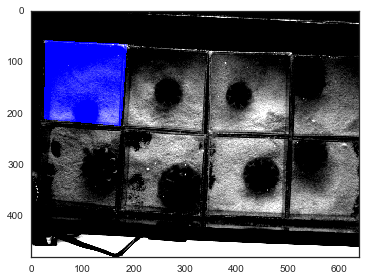

In [14]:
# Make grayscale image that is now RGB
im = np.dstack(3*[skimage.img_as_float(ic[0])])

# Max out blue channel
im[roi,2] = skimage.dtype_limits(im)[1]

# Look at the image
with sns.axes_style('white'):
    skimage.io.imshow(im)

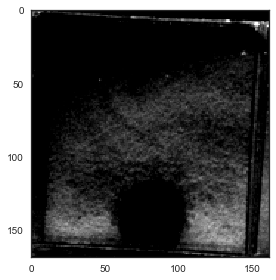

In [15]:
# Define load_func that only gives region bounding ROI
def load_roi(fname, roi_bbox=None, **kwargs):
    """
    Image loading function to only load ROI.
    """
    if roi_bbox is None:
        return skimage.io.imread(fname)[:,:,0]
    else:
        return skimage.io.imread(fname)[:,:,0][roi_bbox]

# Load image collection
ic = skimage.io.ImageCollection(im_glob, conserve_memory=True, 
                                load_func=load_roi, roi_bbox=roi_bbox)

# Look at first image
with sns.axes_style('white'):
    skimage.io.imshow(ic[0])

In [16]:
# Set up NumPy array to store total pixel intensity
total_int = np.empty(len(t))

# Look through and compute total intensity in the ROI
for i, im in enumerate(ic):
    total_int[i] = ic[i][roi_box].sum()

C:\Users\andre_000\Anaconda3\lib\site-packages\skimage\external\tifffile\tifffile.py:1794: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


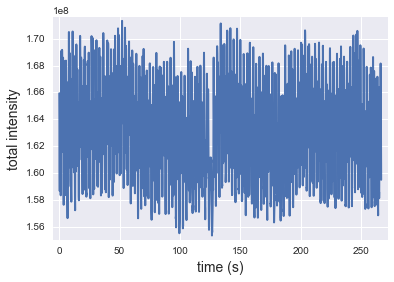

In [17]:
plt.plot(t, total_int)
plt.xlabel('time (s)')
plt.ylabel('total intensity')
plt.margins(0.02)

In [18]:
total_int -= total_int.mean()
total_int = 1 + 2 / (total_int.max() - total_int.min()) \
                * (total_int - total_int.max())

In [19]:
jelly1Day = pulsePerInterval(total_int)
means = draw_bs_reps_mean(jelly1Day)
meanEstimate = sum(list(means)) / len(list(means))
# 95% confidence intervals for number of pulses per "interval"
confidence = np.percentile(means, [2.5, 97.5])
print("""
Jellyfish 1 (Day) : {:.3f}. The 95% conf int : [{:.3f}, {:.3f}]

""".format(meanEstimate, confidence[0], confidence[1]))


Jellyfish 1 (Day) : 7.616. The 95% conf int : [7.140, 8.120]




In [20]:
p = bokeh.plotting.figure(height=300, width=650, x_axis_label='time (s)',
                          y_axis_label='normalized intensity')
p.line(t, total_int, line_join='bevel')
bokeh.io.show(p)

In [21]:
# Jellyfish 2
verts1 = [(181.21542045676108, 66.994922206205729), (177.4779993880249, 223.9666070931255), (338.18710534368086, 235.17887029933411), (345.66194748115322, 79.452992435326337)]

In [22]:
ic = skimage.io.ImageCollection(im_glob, conserve_memory=True)
def squish_rgb(fname, **kwargs):
    """
    Only take one channel. (Need to explicitly have the **kwargs to play
    nicely with skimage.io.ImageCollection.)
    """
    im = skimage.io.imread(fname)
    return im[:,:,0]

ic = skimage.io.ImageCollection(im_glob, conserve_memory=True, 
                                load_func=squish_rgb)
fps = 15
t = np.arange(0, len(ic)) / fps
roi1, roi_bbox1, roi_box1 = bebi103.verts_to_roi(verts1, *ic[0].shape)

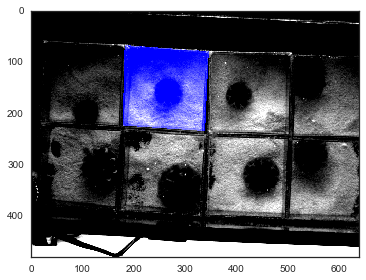

In [23]:
# Make grayscale image that is now RGB
im = np.dstack(3*[skimage.img_as_float(ic[0])])

# Max out blue channel
im[roi1,2] = skimage.dtype_limits(im)[1]

# Look at the image
with sns.axes_style('white'):
    skimage.io.imshow(im)

In [24]:
# Set up NumPy array to store total pixel intensity
total_int = np.empty(len(t))

# Look through and compute total intensity in the ROI
for i, im in enumerate(ic):
    total_int[i] = ic[i][roi_box1].sum()

C:\Users\andre_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 169
C:\Users\andre_000\Anaconda3\lib\site-packages\skimage\external\tifffile\tifffile.py:1794: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


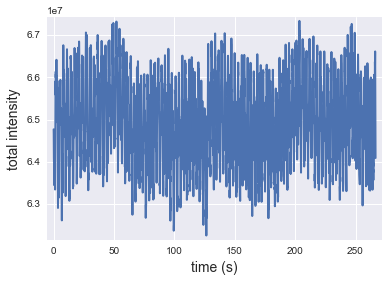

In [25]:
plt.plot(t, total_int)
plt.xlabel('time (s)')
plt.ylabel('total intensity')
plt.margins(0.02)

In [26]:
total_int -= total_int.mean()
total_int = 1 + 2 / (total_int.max() - total_int.min()) \
                * (total_int - total_int.max())

In [27]:
jelly2Day = pulsePerInterval(total_int)
means = draw_bs_reps_mean(jelly2Day)
meanEstimate = sum(list(means)) / len(list(means))
# 95% confidence intervals for number of pulses per "interval"
confidence = np.percentile(means, [2.5, 97.5])
print("""
Jellyfish 2 (Day) : {:.3f}. The 95% conf int : [{:.3f}, {:.3f}]

""".format(meanEstimate, confidence[0], confidence[1]))


Jellyfish 2 (Day) : 6.700. The 95% conf int : [6.060, 7.320]




In [28]:
p = bokeh.plotting.figure(height=300, width=650, x_axis_label='time (s)',
                          y_axis_label='normalized intensity')
p.line(t, total_int, line_join='bevel')
bokeh.io.show(p)

In [29]:
# Jellyfish 3
verts2 = [(343.1703334353291, 76.961378389502215), (339.43291236659292, 236.42467732224617), (501.38782534516099, 243.89951945971853), (507.61686045972124, 79.452992435326337)]


In [30]:
ic = skimage.io.ImageCollection(im_glob, conserve_memory=True)
def squish_rgb(fname, **kwargs):
    """
    Only take one channel. (Need to explicitly have the **kwargs to play
    nicely with skimage.io.ImageCollection.)
    """
    im = skimage.io.imread(fname)
    return im[:,:,0]

ic = skimage.io.ImageCollection(im_glob, conserve_memory=True, 
                                load_func=squish_rgb)
fps = 15
t = np.arange(0, len(ic)) / fps
roi2, roi_bbox2, roi_box2 = bebi103.verts_to_roi(verts2, *ic[0].shape)

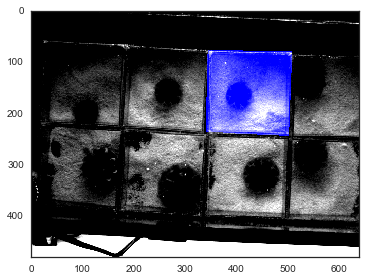

In [31]:
# Make grayscale image that is now RGB
im = np.dstack(3*[skimage.img_as_float(ic[0])])

# Max out blue channel
im[roi2,2] = skimage.dtype_limits(im)[1]

# Look at the image
with sns.axes_style('white'):
    skimage.io.imshow(im)

In [32]:
# Set up NumPy array to store total pixel intensity
total_int = np.empty(len(t))

# Look through and compute total intensity in the ROI
for i, im in enumerate(ic):
    total_int[i] = ic[i][roi_box2].sum()

C:\Users\andre_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 168
C:\Users\andre_000\Anaconda3\lib\site-packages\skimage\external\tifffile\tifffile.py:1794: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


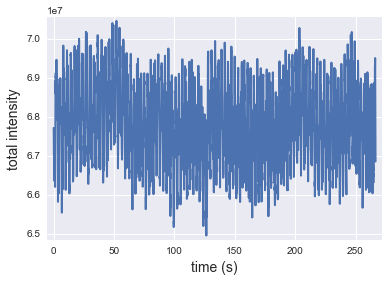

In [33]:
plt.plot(t, total_int)
plt.xlabel('time (s)')
plt.ylabel('total intensity')
plt.margins(0.02)

In [34]:
total_int -= total_int.mean()
total_int = 1 + 2 / (total_int.max() - total_int.min()) \
                * (total_int - total_int.max())

In [35]:
jelly3Day = pulsePerInterval(total_int)
means = draw_bs_reps_mean(jelly3Day)
meanEstimate = sum(list(means)) / len(list(means))
# 95% confidence intervals for number of pulses per "interval"
confidence = np.percentile(means, [2.5, 97.5])
print("""
Jellyfish 3 (Day) : {:.3f}. The 95% conf int : [{:.3f}, {:.3f}]

""".format(meanEstimate, confidence[0], confidence[1]))


Jellyfish 3 (Day) : 6.700. The 95% conf int : [6.060, 7.340]




In [36]:
p = bokeh.plotting.figure(height=300, width=650, x_axis_label='time (s)',
                          y_axis_label='normalized intensity')
p.line(t, total_int, line_join='bevel')
bokeh.io.show(p)

In [37]:
# Jellyfish 4
verts3 = [(506.37105343680923, 83.190413504062519), (503.87943939098511, 240.16209839098235), (638.42659786548768, 248.88274755136678), (635.93498381966356, 90.665255641534884)]

In [38]:
ic = skimage.io.ImageCollection(im_glob, conserve_memory=True)
def squish_rgb(fname, **kwargs):
    """
    Only take one channel. (Need to explicitly have the **kwargs to play
    nicely with skimage.io.ImageCollection.)
    """
    im = skimage.io.imread(fname)
    return im[:,:,0]

ic = skimage.io.ImageCollection(im_glob, conserve_memory=True, 
                                load_func=squish_rgb)
fps = 15
t = np.arange(0, len(ic)) / fps
roi3, roi_bbox3, roi_box3 = bebi103.verts_to_roi(verts3, *ic[0].shape)

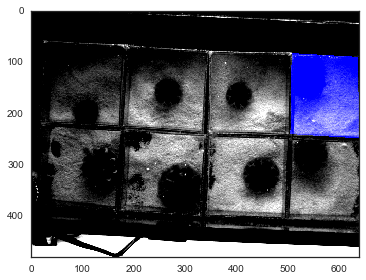

In [39]:
# Make grayscale image that is now RGB
im = np.dstack(3*[skimage.img_as_float(ic[0])])

# Max out blue channel
im[roi3,2] = skimage.dtype_limits(im)[1]

# Look at the image
with sns.axes_style('white'):
    skimage.io.imshow(im)

In [40]:
# Set up NumPy array to store total pixel intensity
total_int = np.empty(len(t))

# Look through and compute total intensity in the ROI
for i, im in enumerate(ic):
    total_int[i] = ic[i][roi_box3].sum()

C:\Users\andre_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 166
C:\Users\andre_000\Anaconda3\lib\site-packages\skimage\external\tifffile\tifffile.py:1794: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


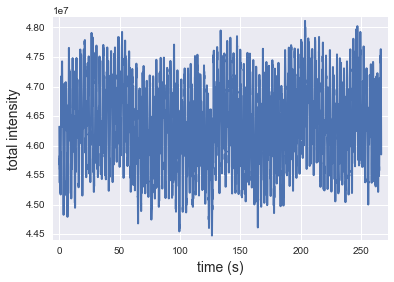

In [41]:
plt.plot(t, total_int)
plt.xlabel('time (s)')
plt.ylabel('total intensity')
plt.margins(0.02)

In [42]:
total_int -= total_int.mean()
total_int = 1 + 2 / (total_int.max() - total_int.min()) \
                * (total_int - total_int.max())

In [43]:
jelly4Day = pulsePerInterval(total_int)
means = draw_bs_reps_mean(jelly4Day)
meanEstimate = sum(list(means)) / len(list(means))
# 95% confidence intervals for number of pulses per "interval"
confidence = np.percentile(means, [2.5, 97.5])
print("""
Jellyfish 4 (Day) : {:.3f}. The 95% conf int : [{:.3f}, {:.3f}]

""".format(meanEstimate, confidence[0], confidence[1]))


Jellyfish 4 (Day) : 7.525. The 95% conf int : [6.740, 8.300]




In [44]:
p = bokeh.plotting.figure(height=300, width=650, x_axis_label='time (s)',
                          y_axis_label='normalized intensity')
p.line(t, total_int, line_join='bevel')
bokeh.io.show(p)

In [45]:
# Jellyfish 5
verts4 = [(26.735349615665427, 216.49176495565314), (181.21542045676108, 226.45822113894963), (166.26573618181635, 385.92152007169358), (30.472770684401624, 372.21764281966091)]

In [46]:
ic = skimage.io.ImageCollection(im_glob, conserve_memory=True)
def squish_rgb(fname, **kwargs):
    """
    Only take one channel. (Need to explicitly have the **kwargs to play
    nicely with skimage.io.ImageCollection.)
    """
    im = skimage.io.imread(fname)
    return im[:,:,0]

ic = skimage.io.ImageCollection(im_glob, conserve_memory=True, 
                                load_func=squish_rgb)
fps = 15
t = np.arange(0, len(ic)) / fps
roi4, roi_bbox4, roi_box4 = bebi103.verts_to_roi(verts4, *ic[0].shape)

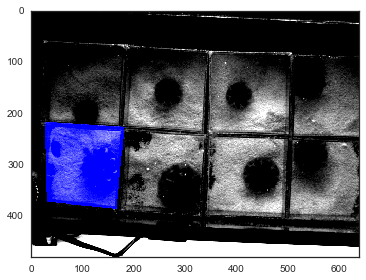

In [47]:
# Make grayscale image that is now RGB
im = np.dstack(3*[skimage.img_as_float(ic[0])])

# Max out blue channel
im[roi4,2] = skimage.dtype_limits(im)[1]

# Look at the image
with sns.axes_style('white'):
    skimage.io.imshow(im)

In [48]:
# Set up NumPy array to store total pixel intensity
total_int = np.empty(len(t))

# Look through and compute total intensity in the ROI
for i, im in enumerate(ic):
    total_int[i] = ic[i][roi_box4].sum()

C:\Users\andre_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 170
C:\Users\andre_000\Anaconda3\lib\site-packages\skimage\external\tifffile\tifffile.py:1794: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


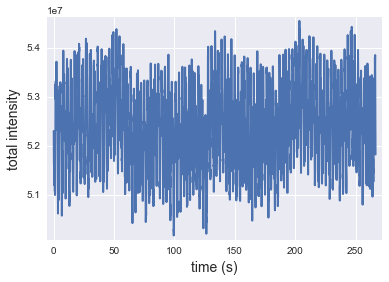

In [49]:
plt.plot(t, total_int)
plt.xlabel('time (s)')
plt.ylabel('total intensity')
plt.margins(0.02)

In [50]:
total_int -= total_int.mean()
total_int = 1 + 2 / (total_int.max() - total_int.min()) \
                * (total_int - total_int.max())

In [51]:
jelly5Day = pulsePerInterval(total_int)
means = draw_bs_reps_mean(jelly5Day)
meanEstimate = sum(list(means)) / len(list(means))
# 95% confidence intervals for number of pulses per "interval"
confidence = np.percentile(means, [2.5, 97.5])
print("""
Jellyfish 5 (Day) : {:.3f}. The 95% conf int : [{:.3f}, {:.3f}]

""".format(meanEstimate, confidence[0], confidence[1]))


Jellyfish 5 (Day) : 7.198. The 95% conf int : [6.440, 7.940]




In [52]:
p = bokeh.plotting.figure(height=300, width=650, x_axis_label='time (s)',
                          y_axis_label='normalized intensity')
p.line(t, total_int, line_join='bevel')
bokeh.io.show(p)

In [53]:
# Jellyfish 6
verts5 = [(178.72380641093696, 231.44144923059787), (340.67871938950498, 236.42467732224617), (334.44968427494467, 399.62539732372625), (167.51154320472841, 388.4131341175177)]

In [54]:
ic = skimage.io.ImageCollection(im_glob, conserve_memory=True)
def squish_rgb(fname, **kwargs):
    """
    Only take one channel. (Need to explicitly have the **kwargs to play
    nicely with skimage.io.ImageCollection.)
    """
    im = skimage.io.imread(fname)
    return im[:,:,0]

ic = skimage.io.ImageCollection(im_glob, conserve_memory=True, 
                                load_func=squish_rgb)
fps = 15
t = np.arange(0, len(ic)) / fps
roi5, roi_bbox5, roi_box5 = bebi103.verts_to_roi(verts5, *ic[0].shape)

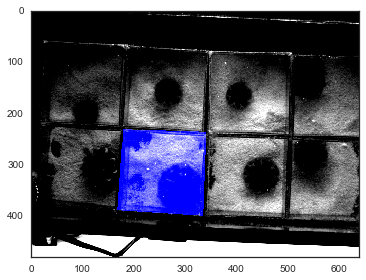

In [55]:
# Make grayscale image that is now RGB
im = np.dstack(3*[skimage.img_as_float(ic[0])])

# Max out blue channel
im[roi5,2] = skimage.dtype_limits(im)[1]

# Look at the image
with sns.axes_style('white'):
    skimage.io.imshow(im)

In [56]:
# Set up NumPy array to store total pixel intensity
total_int = np.empty(len(t))

# Look through and compute total intensity in the ROI
for i, im in enumerate(ic):
    total_int[i] = ic[i][roi_box5].sum()

C:\Users\andre_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 169
C:\Users\andre_000\Anaconda3\lib\site-packages\skimage\external\tifffile\tifffile.py:1794: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


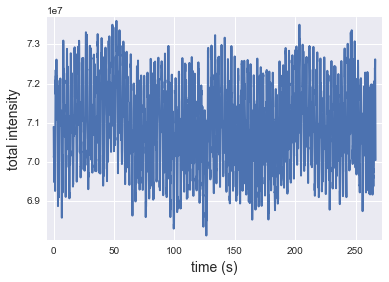

In [57]:
plt.plot(t, total_int)
plt.xlabel('time (s)')
plt.ylabel('total intensity')
plt.margins(0.02)

In [58]:
total_int -= total_int.mean()
total_int = 1 + 2 / (total_int.max() - total_int.min()) \
                * (total_int - total_int.max())

In [59]:
jelly6Day = pulsePerInterval(total_int)
means = draw_bs_reps_mean(jelly6Day)
meanEstimate = sum(list(means)) / len(list(means))
# 95% confidence intervals for number of pulses per "interval"
confidence = np.percentile(means, [2.5, 97.5])
print("""
Jellyfish 6 (Day) : {:.3f}. The 95% conf int : [{:.3f}, {:.3f}]

""".format(meanEstimate, confidence[0], confidence[1]))


Jellyfish 6 (Day) : 6.495. The 95% conf int : [5.820, 7.140]




In [60]:
p = bokeh.plotting.figure(height=300, width=650, x_axis_label='time (s)',
                          y_axis_label='normalized intensity')
p.line(t, total_int, line_join='bevel')
bokeh.io.show(p)

In [61]:
# Jellyfish 7
verts6 = [(339.43291236659292, 242.65371243680647), (334.44968427494467, 407.10023946119861), (492.66717618477651, 413.32927457575892), (506.37105343680923, 245.14532648263059)]

In [62]:
ic = skimage.io.ImageCollection(im_glob, conserve_memory=True)
def squish_rgb(fname, **kwargs):
    """
    Only take one channel. (Need to explicitly have the **kwargs to play
    nicely with skimage.io.ImageCollection.)
    """
    im = skimage.io.imread(fname)
    return im[:,:,0]

ic = skimage.io.ImageCollection(im_glob, conserve_memory=True, 
                                load_func=squish_rgb)
fps = 15
t = np.arange(0, len(ic)) / fps
roi6, roi_bbox6, roi_box6 = bebi103.verts_to_roi(verts6, *ic[0].shape)

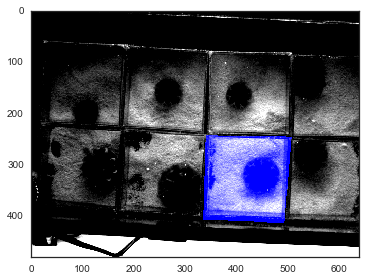

In [63]:
# Make grayscale image that is now RGB
im = np.dstack(3*[skimage.img_as_float(ic[0])])

# Max out blue channel
im[roi6,2] = skimage.dtype_limits(im)[1]

# Look at the image
with sns.axes_style('white'):
    skimage.io.imshow(im)

In [64]:
# Set up NumPy array to store total pixel intensity
total_int = np.empty(len(t))

# Look through and compute total intensity in the ROI
for i, im in enumerate(ic):
    total_int[i] = ic[i][roi_box6].sum()

C:\Users\andre_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 172
C:\Users\andre_000\Anaconda3\lib\site-packages\skimage\external\tifffile\tifffile.py:1794: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


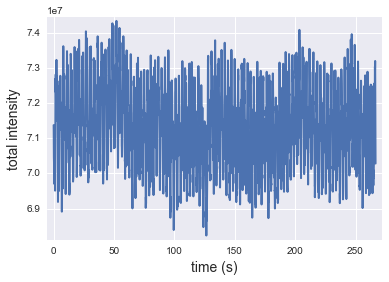

In [65]:
plt.plot(t, total_int)
plt.xlabel('time (s)')
plt.ylabel('total intensity')
plt.margins(0.02)

In [66]:
total_int -= total_int.mean()
total_int = 1 + 2 / (total_int.max() - total_int.min()) \
                * (total_int - total_int.max())

In [67]:
jelly7Day = pulsePerInterval(total_int)
means = draw_bs_reps_mean(jelly7Day)
meanEstimate = sum(list(means)) / len(list(means))
# 95% confidence intervals for number of pulses per "interval"
confidence = np.percentile(means, [2.5, 97.5])
print("""
Jellyfish 7 (Day) : {:.3f}. The 95% conf int : [{:.3f}, {:.3f}]

""".format(meanEstimate, confidence[0], confidence[1]))


Jellyfish 7 (Day) : 6.788. The 95% conf int : [6.080, 7.460]




In [68]:
p = bokeh.plotting.figure(height=300, width=650, x_axis_label='time (s)',
                          y_axis_label='normalized intensity')
p.line(t, total_int, line_join='bevel')
bokeh.io.show(p)

In [69]:
# Jellyfish 8
verts7 = [(505.12524641389712, 243.89951945971853), (638.42659786548768, 246.39113350554265), (630.95175572801531, 415.82088862158309), (493.91298320768863, 413.32927457575892)]

In [70]:
ic = skimage.io.ImageCollection(im_glob, conserve_memory=True)
def squish_rgb(fname, **kwargs):
    """
    Only take one channel. (Need to explicitly have the **kwargs to play
    nicely with skimage.io.ImageCollection.)
    """
    im = skimage.io.imread(fname)
    return im[:,:,0]

ic = skimage.io.ImageCollection(im_glob, conserve_memory=True, 
                                load_func=squish_rgb)
fps = 15
t = np.arange(0, len(ic)) / fps
roi7, roi_bbox7, roi_box7 = bebi103.verts_to_roi(verts7, *ic[0].shape)

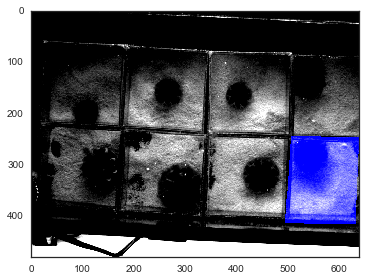

In [71]:
# Make grayscale image that is now RGB
im = np.dstack(3*[skimage.img_as_float(ic[0])])

# Max out blue channel
im[roi7,2] = skimage.dtype_limits(im)[1]

# Look at the image
with sns.axes_style('white'):
    skimage.io.imshow(im)

In [72]:
# Set up NumPy array to store total pixel intensity
total_int = np.empty(len(t))

# Look through and compute total intensity in the ROI
for i, im in enumerate(ic):
    total_int[i] = ic[i][roi_box7].sum()

C:\Users\andre_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 173
C:\Users\andre_000\Anaconda3\lib\site-packages\skimage\external\tifffile\tifffile.py:1794: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


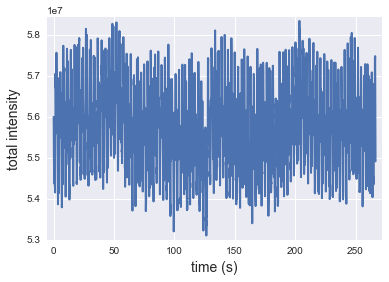

In [73]:
plt.plot(t, total_int)
plt.xlabel('time (s)')
plt.ylabel('total intensity')
plt.margins(0.02)

In [74]:
total_int -= total_int.mean()
total_int = 1 + 2 / (total_int.max() - total_int.min()) \
                * (total_int - total_int.max())

In [75]:
jelly8Day = pulsePerInterval(total_int)
means = draw_bs_reps_mean(jelly8Day)
meanEstimate = sum(list(means)) / len(list(means))
# 95% confidence intervals for number of pulses per "interval"
confidence = np.percentile(means, [2.5, 97.5])
print("""
Jellyfish 8 (Day) : {:.3f}. The 95% conf int : [{:.3f}, {:.3f}]

""".format(meanEstimate, confidence[0], confidence[1]))


Jellyfish 8 (Day) : 6.981. The 95% conf int : [6.420, 7.540]




In [76]:
p = bokeh.plotting.figure(height=300, width=650, x_axis_label='time (s)',
                          y_axis_label='normalized intensity')
p.line(t, total_int, line_join='bevel')
bokeh.io.show(p)

## Night time Jellyfish Data##

We now repeat the above steps, but for nighttime jellyfish data. Normalized intensity data shown with Bokeh.

In [77]:
# The directory containing daytime data
data_dir = '../data/Cassiopea_Pulsation/night'

# Glob string for images
im_glob = os.path.join(data_dir, '*.TIF')

# Get list of files in directory
im_list = glob.glob(im_glob)

# Let's look at the first 10 entries
im_list[:10]

['../data/Cassiopea_Pulsation/night\\Frame_545000.TIF',
 '../data/Cassiopea_Pulsation/night\\Frame_545001.TIF',
 '../data/Cassiopea_Pulsation/night\\Frame_545002.TIF',
 '../data/Cassiopea_Pulsation/night\\Frame_545003.TIF',
 '../data/Cassiopea_Pulsation/night\\Frame_545004.TIF',
 '../data/Cassiopea_Pulsation/night\\Frame_545005.TIF',
 '../data/Cassiopea_Pulsation/night\\Frame_545006.TIF',
 '../data/Cassiopea_Pulsation/night\\Frame_545007.TIF',
 '../data/Cassiopea_Pulsation/night\\Frame_545008.TIF',
 '../data/Cassiopea_Pulsation/night\\Frame_545009.TIF']

In [78]:
# Jellyfish 1
verts = [(26.735349615665427, 58.274273045821303), (25.489542592753367, 211.5085368640049), (174.98638534220078, 225.21241411603756), (186.19864854840932, 65.749115183293668)]

In [79]:
ic = skimage.io.ImageCollection(im_glob, conserve_memory=True)
len(ic)

4000

In [80]:
def squish_rgb(fname, **kwargs):
    """
    Only take one channel. (Need to explicitly have the **kwargs to play
    nicely with skimage.io.ImageCollection.)
    """
    im = skimage.io.imread(fname)
    return im[:,:,0]

ic = skimage.io.ImageCollection(im_glob, conserve_memory=True, 
                                load_func=squish_rgb)

In [81]:
fps = 15
t = np.arange(0, len(ic)) / fps

In [82]:
roi, roi_bbox, roi_box = bebi103.verts_to_roi(verts, *ic[0].shape)

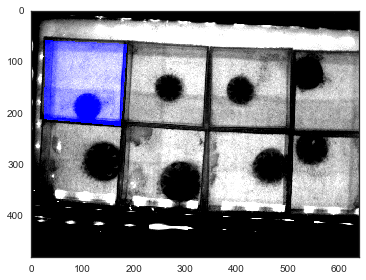

In [83]:
# Make grayscale image that is now RGB
im = np.dstack(3*[skimage.img_as_float(ic[0])])

# Max out blue channel
im[roi,2] = skimage.dtype_limits(im)[1]

# Look at the image
with sns.axes_style('white'):
    skimage.io.imshow(im)

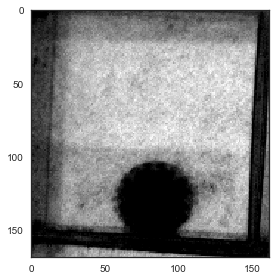

In [84]:
# Define load_func that only gives region bounding ROI
def load_roi(fname, roi_bbox=None, **kwargs):
    """
    Image loading function to only load ROI.
    """
    if roi_bbox is None:
        return skimage.io.imread(fname)[:,:,0]
    else:
        return skimage.io.imread(fname)[:,:,0][roi_bbox]

# Load image collection
ic = skimage.io.ImageCollection(im_glob, conserve_memory=True, 
                                load_func=load_roi, roi_bbox=roi_bbox)

# Look at first image
with sns.axes_style('white'):
    skimage.io.imshow(ic[0])

In [85]:
# Set up NumPy array to store total pixel intensity
total_int = np.empty(len(t))

# Look through and compute total intensity in the ROI
for i, im in enumerate(ic):
    total_int[i] = ic[i][roi_box].sum()

In [86]:
total_int -= total_int.mean()
total_int = 1 + 2 / (total_int.max() - total_int.min()) \
                * (total_int - total_int.max())

In [87]:
jelly1Night = pulsePerInterval(total_int)
means = draw_bs_reps_mean(jelly1Night)
meanEstimate = sum(list(means)) / len(list(means))
# 95% confidence intervals for number of pulses per "interval"
confidence = np.percentile(means, [2.5, 97.5])
print("""
Jellyfish 1 (Night) : {:.3f}. The 95% conf int : [{:.3f}, {:.3f}]

""".format(meanEstimate, confidence[0], confidence[1]))


Jellyfish 1 (Night) : 13.922. The 95% conf int : [10.340, 17.700]




In [88]:
p = bokeh.plotting.figure(height=300, width=650, x_axis_label='time (s)',
                          y_axis_label='normalized intensity')
p.line(t, total_int, line_join='bevel')
bokeh.io.show(p)

In [89]:
# Jellyfish 2
verts1 = [(181.21542045676108, 66.994922206205729), (177.4779993880249, 223.9666070931255), (338.18710534368086, 235.17887029933411), (345.66194748115322, 79.452992435326337)]

In [90]:
ic = skimage.io.ImageCollection(im_glob, conserve_memory=True)
def squish_rgb(fname, **kwargs):
    """
    Only take one channel. (Need to explicitly have the **kwargs to play
    nicely with skimage.io.ImageCollection.)
    """
    im = skimage.io.imread(fname)
    return im[:,:,0]

ic = skimage.io.ImageCollection(im_glob, conserve_memory=True, 
                                load_func=squish_rgb)
fps = 15
t = np.arange(0, len(ic)) / fps
roi1, roi_bbox1, roi_box1 = bebi103.verts_to_roi(verts1, *ic[0].shape)

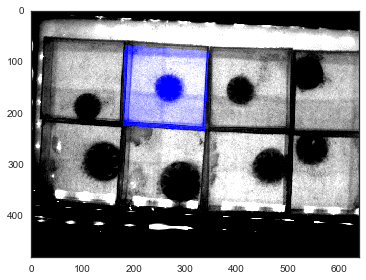

In [91]:
# Make grayscale image that is now RGB
im = np.dstack(3*[skimage.img_as_float(ic[0])])

# Max out blue channel
im[roi1,2] = skimage.dtype_limits(im)[1]

# Look at the image
with sns.axes_style('white'):
    skimage.io.imshow(im)

In [92]:
# Set up NumPy array to store total pixel intensity
total_int = np.empty(len(t))

# Look through and compute total intensity in the ROI
for i, im in enumerate(ic):
    total_int[i] = ic[i][roi_box1].sum()

C:\Users\andre_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 169


In [93]:
total_int -= total_int.mean()
total_int = 1 + 2 / (total_int.max() - total_int.min()) \
                * (total_int - total_int.max())

In [94]:
jelly2Night = pulsePerInterval(total_int)
means = draw_bs_reps_mean(jelly2Night)
meanEstimate = sum(list(means)) / len(list(means))
# 95% confidence intervals for number of pulses per "interval"
confidence = np.percentile(means, [2.5, 97.5])
print("""
Jellyfish 2 (Night) : {:.3f}. The 95% conf int : [{:.3f}, {:.3f}]

""".format(meanEstimate, confidence[0], confidence[1]))


Jellyfish 2 (Night) : 16.975. The 95% conf int : [14.160, 19.760]




In [95]:
p = bokeh.plotting.figure(height=300, width=650, x_axis_label='time (s)',
                          y_axis_label='normalized intensity')
p.line(t, total_int, line_join='bevel')
bokeh.io.show(p)

In [96]:
# Jellyfish 3
verts2 = [(343.1703334353291, 76.961378389502215), (339.43291236659292, 236.42467732224617), (501.38782534516099, 243.89951945971853), (507.61686045972124, 79.452992435326337)]


In [97]:
ic = skimage.io.ImageCollection(im_glob, conserve_memory=True)
def squish_rgb(fname, **kwargs):
    """
    Only take one channel. (Need to explicitly have the **kwargs to play
    nicely with skimage.io.ImageCollection.)
    """
    im = skimage.io.imread(fname)
    return im[:,:,0]

ic = skimage.io.ImageCollection(im_glob, conserve_memory=True, 
                                load_func=squish_rgb)
fps = 15
t = np.arange(0, len(ic)) / fps
roi2, roi_bbox2, roi_box2 = bebi103.verts_to_roi(verts2, *ic[0].shape)

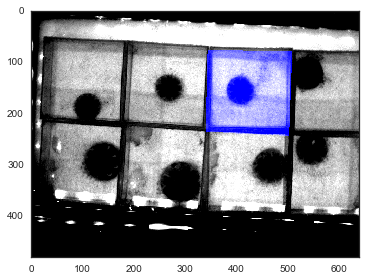

In [98]:
# Make grayscale image that is now RGB
im = np.dstack(3*[skimage.img_as_float(ic[0])])

# Max out blue channel
im[roi2,2] = skimage.dtype_limits(im)[1]

# Look at the image
with sns.axes_style('white'):
    skimage.io.imshow(im)

In [99]:
# Set up NumPy array to store total pixel intensity
total_int = np.empty(len(t))

# Look through and compute total intensity in the ROI
for i, im in enumerate(ic):
    total_int[i] = ic[i][roi_box2].sum()

C:\Users\andre_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 168


In [100]:
total_int -= total_int.mean()
total_int = 1 + 2 / (total_int.max() - total_int.min()) \
                * (total_int - total_int.max())

In [101]:
jelly3Night = pulsePerInterval(total_int)
means = draw_bs_reps_mean(jelly3Night)
meanEstimate = sum(list(means)) / len(list(means))
# 95% confidence intervals for number of pulses per "interval"
confidence = np.percentile(means, [2.5, 97.5])
print("""
Jellyfish 3 (Night) : {:.3f}. The 95% conf int : [{:.3f}, {:.3f}]

""".format(meanEstimate, confidence[0], confidence[1]))


Jellyfish 3 (Night) : 17.062. The 95% conf int : [14.000, 19.980]




In [102]:
p = bokeh.plotting.figure(height=300, width=650, x_axis_label='time (s)',
                          y_axis_label='normalized intensity')
p.line(t, total_int, line_join='bevel')
bokeh.io.show(p)

In [103]:
# Jellyfish 4
verts3 = [(506.37105343680923, 83.190413504062519), (503.87943939098511, 240.16209839098235), (638.42659786548768, 248.88274755136678), (635.93498381966356, 90.665255641534884)]

In [104]:
ic = skimage.io.ImageCollection(im_glob, conserve_memory=True)
def squish_rgb(fname, **kwargs):
    """
    Only take one channel. (Need to explicitly have the **kwargs to play
    nicely with skimage.io.ImageCollection.)
    """
    im = skimage.io.imread(fname)
    return im[:,:,0]

ic = skimage.io.ImageCollection(im_glob, conserve_memory=True, 
                                load_func=squish_rgb)
fps = 15
t = np.arange(0, len(ic)) / fps
roi3, roi_bbox3, roi_box3 = bebi103.verts_to_roi(verts3, *ic[0].shape)

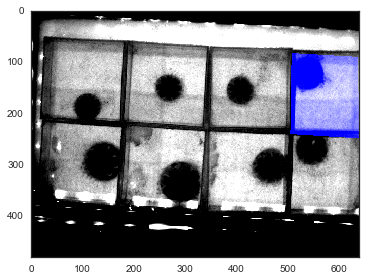

In [105]:
# Make grayscale image that is now RGB
im = np.dstack(3*[skimage.img_as_float(ic[0])])

# Max out blue channel
im[roi3,2] = skimage.dtype_limits(im)[1]

# Look at the image
with sns.axes_style('white'):
    skimage.io.imshow(im)

In [106]:
# Set up NumPy array to store total pixel intensity
total_int = np.empty(len(t))

# Look through and compute total intensity in the ROI
for i, im in enumerate(ic):
    total_int[i] = ic[i][roi_box3].sum()

C:\Users\andre_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 166


In [107]:
total_int -= total_int.mean()
total_int = 1 + 2 / (total_int.max() - total_int.min()) \
                * (total_int - total_int.max())

In [108]:
jelly4Night = pulsePerInterval(total_int)
means = draw_bs_reps_mean(jelly4Night)
meanEstimate = sum(list(means)) / len(list(means))
# 95% confidence intervals for number of pulses per "interval"
confidence = np.percentile(means, [2.5, 97.5])
print("""
Jellyfish 4 (Night) : {:.3f}. The 95% conf int : [{:.3f}, {:.3f}]

""".format(meanEstimate, confidence[0], confidence[1]))


Jellyfish 4 (Night) : 16.954. The 95% conf int : [14.200, 19.640]




In [109]:
p = bokeh.plotting.figure(height=300, width=650, x_axis_label='time (s)',
                          y_axis_label='normalized intensity')
p.line(t, total_int, line_join='bevel')
bokeh.io.show(p)

In [110]:
# Jellyfish 5
verts4 = [(26.735349615665427, 216.49176495565314), (181.21542045676108, 226.45822113894963), (166.26573618181635, 385.92152007169358), (30.472770684401624, 372.21764281966091)]

In [111]:
ic = skimage.io.ImageCollection(im_glob, conserve_memory=True)
def squish_rgb(fname, **kwargs):
    """
    Only take one channel. (Need to explicitly have the **kwargs to play
    nicely with skimage.io.ImageCollection.)
    """
    im = skimage.io.imread(fname)
    return im[:,:,0]

ic = skimage.io.ImageCollection(im_glob, conserve_memory=True, 
                                load_func=squish_rgb)
fps = 15
t = np.arange(0, len(ic)) / fps
roi4, roi_bbox4, roi_box4 = bebi103.verts_to_roi(verts4, *ic[0].shape)

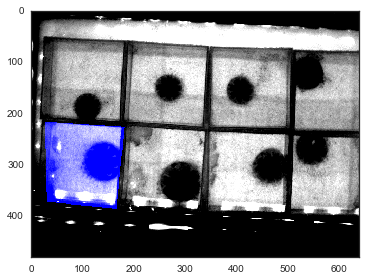

In [112]:
# Make grayscale image that is now RGB
im = np.dstack(3*[skimage.img_as_float(ic[0])])

# Max out blue channel
im[roi4,2] = skimage.dtype_limits(im)[1]

# Look at the image
with sns.axes_style('white'):
    skimage.io.imshow(im)

In [113]:
# Set up NumPy array to store total pixel intensity
total_int = np.empty(len(t))

# Look through and compute total intensity in the ROI
for i, im in enumerate(ic):
    total_int[i] = ic[i][roi_box4].sum()

C:\Users\andre_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 170


In [114]:
total_int -= total_int.mean()
total_int = 1 + 2 / (total_int.max() - total_int.min()) \
                * (total_int - total_int.max())

In [115]:
jelly5Night = pulsePerInterval(total_int)
means = draw_bs_reps_mean(jelly5Night)
meanEstimate = sum(list(means)) / len(list(means))
# 95% confidence intervals for number of pulses per "interval"
confidence = np.percentile(means, [2.5, 97.5])
print("""
Jellyfish 5 (Night) : {:.3f}. The 95% conf int : [{:.3f}, {:.3f}]

""".format(meanEstimate, confidence[0], confidence[1]))


Jellyfish 5 (Night) : 16.013. The 95% conf int : [13.060, 18.960]




In [116]:
p = bokeh.plotting.figure(height=300, width=650, x_axis_label='time (s)',
                          y_axis_label='normalized intensity')
p.line(t, total_int, line_join='bevel')
bokeh.io.show(p)

In [117]:
# Jellyfish 6
verts5 = [(178.72380641093696, 231.44144923059787), (340.67871938950498, 236.42467732224617), (334.44968427494467, 399.62539732372625), (167.51154320472841, 388.4131341175177)]

In [118]:
ic = skimage.io.ImageCollection(im_glob, conserve_memory=True)
def squish_rgb(fname, **kwargs):
    """
    Only take one channel. (Need to explicitly have the **kwargs to play
    nicely with skimage.io.ImageCollection.)
    """
    im = skimage.io.imread(fname)
    return im[:,:,0]

ic = skimage.io.ImageCollection(im_glob, conserve_memory=True, 
                                load_func=squish_rgb)
fps = 15
t = np.arange(0, len(ic)) / fps
roi5, roi_bbox5, roi_box5 = bebi103.verts_to_roi(verts5, *ic[0].shape)

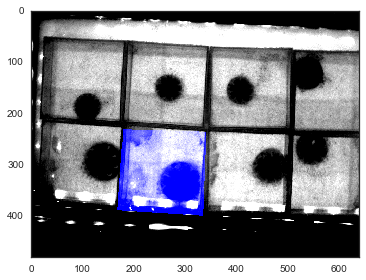

In [119]:
# Make grayscale image that is now RGB
im = np.dstack(3*[skimage.img_as_float(ic[0])])

# Max out blue channel
im[roi5,2] = skimage.dtype_limits(im)[1]

# Look at the image
with sns.axes_style('white'):
    skimage.io.imshow(im)

In [120]:
# Set up NumPy array to store total pixel intensity
total_int = np.empty(len(t))

# Look through and compute total intensity in the ROI
for i, im in enumerate(ic):
    total_int[i] = ic[i][roi_box5].sum()

C:\Users\andre_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 169


In [121]:
total_int -= total_int.mean()
total_int = 1 + 2 / (total_int.max() - total_int.min()) \
                * (total_int - total_int.max())

In [122]:
jelly6Night = pulsePerInterval(total_int)
means = draw_bs_reps_mean(jelly6Night)
meanEstimate = sum(list(means)) / len(list(means))
# 95% confidence intervals for number of pulses per "interval"
confidence = np.percentile(means, [2.5, 97.5])
print("""
Jellyfish 6 (Night) : {:.3f}. The 95% conf int : [{:.3f}, {:.3f}]

""".format(meanEstimate, confidence[0], confidence[1]))


Jellyfish 6 (Night) : 16.805. The 95% conf int : [13.920, 19.700]




In [123]:
p = bokeh.plotting.figure(height=300, width=650, x_axis_label='time (s)',
                          y_axis_label='normalized intensity')
p.line(t, total_int, line_join='bevel')
bokeh.io.show(p)

In [124]:
# Jellyfish 7
verts6 = [(339.43291236659292, 242.65371243680647), (334.44968427494467, 407.10023946119861), (492.66717618477651, 413.32927457575892), (506.37105343680923, 245.14532648263059)]

In [125]:
ic = skimage.io.ImageCollection(im_glob, conserve_memory=True)
def squish_rgb(fname, **kwargs):
    """
    Only take one channel. (Need to explicitly have the **kwargs to play
    nicely with skimage.io.ImageCollection.)
    """
    im = skimage.io.imread(fname)
    return im[:,:,0]

ic = skimage.io.ImageCollection(im_glob, conserve_memory=True, 
                                load_func=squish_rgb)
fps = 15
t = np.arange(0, len(ic)) / fps
roi6, roi_bbox6, roi_box6 = bebi103.verts_to_roi(verts6, *ic[0].shape)

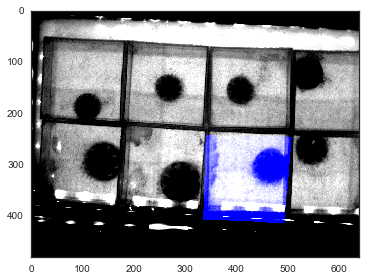

In [126]:
# Make grayscale image that is now RGB
im = np.dstack(3*[skimage.img_as_float(ic[0])])

# Max out blue channel
im[roi6,2] = skimage.dtype_limits(im)[1]

# Look at the image
with sns.axes_style('white'):
    skimage.io.imshow(im)

In [127]:
# Set up NumPy array to store total pixel intensity
total_int = np.empty(len(t))

# Look through and compute total intensity in the ROI
for i, im in enumerate(ic):
    total_int[i] = ic[i][roi_box6].sum()

C:\Users\andre_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 172


In [128]:
total_int -= total_int.mean()
total_int = 1 + 2 / (total_int.max() - total_int.min()) \
                * (total_int - total_int.max())

In [129]:
jelly7Night = pulsePerInterval(total_int)
means = draw_bs_reps_mean(jelly7Night)
meanEstimate = sum(list(means)) / len(list(means))
# 95% confidence intervals for number of pulses per "interval"
confidence = np.percentile(means, [2.5, 97.5])
print("""
Jellyfish 7 (Night) : {:.3f}. The 95% conf int : [{:.3f}, {:.3f}]

""".format(meanEstimate, confidence[0], confidence[1]))


Jellyfish 7 (Night) : 15.302. The 95% conf int : [12.280, 18.320]




In [130]:
p = bokeh.plotting.figure(height=300, width=650, x_axis_label='time (s)',
                          y_axis_label='normalized intensity')
p.line(t, total_int, line_join='bevel')
bokeh.io.show(p)

In [131]:
# Jellyfish 8
verts7 = [(505.12524641389712, 243.89951945971853), (638.42659786548768, 246.39113350554265), (630.95175572801531, 415.82088862158309), (493.91298320768863, 413.32927457575892)]

In [132]:
ic = skimage.io.ImageCollection(im_glob, conserve_memory=True)
def squish_rgb(fname, **kwargs):
    """
    Only take one channel. (Need to explicitly have the **kwargs to play
    nicely with skimage.io.ImageCollection.)
    """
    im = skimage.io.imread(fname)
    return im[:,:,0]

ic = skimage.io.ImageCollection(im_glob, conserve_memory=True, 
                                load_func=squish_rgb)
fps = 15
t = np.arange(0, len(ic)) / fps
roi7, roi_bbox7, roi_box7 = bebi103.verts_to_roi(verts7, *ic[0].shape)

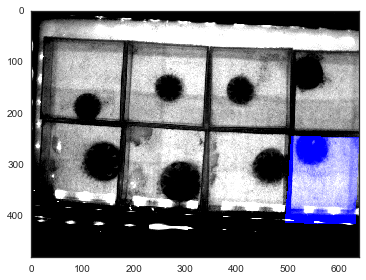

In [133]:
# Make grayscale image that is now RGB
im = np.dstack(3*[skimage.img_as_float(ic[0])])

# Max out blue channel
im[roi7,2] = skimage.dtype_limits(im)[1]

# Look at the image
with sns.axes_style('white'):
    skimage.io.imshow(im)

In [134]:
# Set up NumPy array to store total pixel intensity
total_int = np.empty(len(t))

# Look through and compute total intensity in the ROI
for i, im in enumerate(ic):
    total_int[i] = ic[i][roi_box7].sum()

C:\Users\andre_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 173


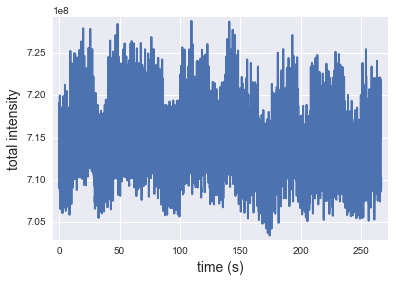

In [135]:
plt.plot(t, total_int)
plt.xlabel('time (s)')
plt.ylabel('total intensity')
plt.margins(0.02)

In [136]:
total_int -= total_int.mean()
total_int = 1 + 2 / (total_int.max() - total_int.min()) \
                * (total_int - total_int.max())

In [137]:
jelly8Night = pulsePerInterval(total_int)
means = draw_bs_reps_mean(jelly8Night)
meanEstimate = sum(list(means)) / len(list(means))
# 95% confidence intervals for number of pulses per "interval"
confidence = np.percentile(means, [2.5, 97.5])
print("""
Jellyfish 8 (Night) : {:.3f}. The 95% conf int : [{:.3f}, {:.3f}]

""".format(meanEstimate, confidence[0], confidence[1]))


Jellyfish 8 (Night) : 14.656. The 95% conf int : [11.640, 17.740]




In [138]:
p = bokeh.plotting.figure(height=300, width=650, x_axis_label='time (s)',
                          y_axis_label='normalized intensity')
p.line(t, total_int, line_join='bevel')
bokeh.io.show(p)

Now, that we have mean estimates and confidence intervals for each jellyfish for both night and day, we will compute p-values to determine if a difference exists between night and daytime frequencies of pulsing. 

**Null hypothesis**: The number of pulses per time interval, for a jellyfish during the night and the same jellyfish during the day, have exactly the same distribution.

**Test statistic**: Difference of means of the distributions

**Simulation**: Follow the simulation described in Tutorial 7a, which is as follows

1) Concatenate the two data sets into one.

2) Randomly scramble the order of the combined data set.

3) Designate the first $n$ entries in this scrambled array to be "control" and the remaining to be "test."

We can take $n$ to be any positive integer less than the size of the combined data set. We will choose it to be the size of the jellyfish nighttime data set.

**Definition**: In this case, what it means to be at least as extreme as the test statistic is that the (absolute value of the) difference of means observed in a simulation trial is greater than the difference of means between the two unconcatenated data sets.

In [139]:
# Compute test statistic for original data set
diff_mean = abs(np.mean(jelly1Day) - np.mean(jelly1Night))

# Draw replicates
perm_reps = draw_perm_reps_diff_mean(jelly1Day, jelly1Night, size=10000)

# Compute p-value
p_val = np.sum(perm_reps >= diff_mean) / len(perm_reps)

print('p-value (jellyfish 1) =', p_val)

p-value (jellyfish 1) = 0.0018


In [140]:
# Compute test statistic for original data set
diff_mean = abs(np.mean(jelly2Day) - np.mean(jelly2Night))

# Draw replicates
perm_reps = draw_perm_reps_diff_mean(jelly2Day, jelly2Night, size=10000)

# Compute p-value
p_val = np.sum(perm_reps >= diff_mean) / len(perm_reps)

print('p-value (jellyfish 2) =', p_val)

p-value (jellyfish 2) = 0.0


In [141]:
# Compute test statistic for original data set
diff_mean = abs(np.mean(jelly3Day) - np.mean(jelly3Night))

# Draw replicates
perm_reps = draw_perm_reps_diff_mean(jelly3Day, jelly3Night, size=10000)

# Compute p-value
p_val = np.sum(perm_reps >= diff_mean) / len(perm_reps)

print('p-value (jellyfish 3) =', p_val)

p-value (jellyfish 3) = 0.0


In [142]:
# Compute test statistic for original data set
diff_mean = abs(np.mean(jelly4Day) - np.mean(jelly4Night))

# Draw replicates
perm_reps = draw_perm_reps_diff_mean(jelly4Day, jelly4Night, size=10000)

# Compute p-value
p_val = np.sum(perm_reps >= diff_mean) / len(perm_reps)

print('p-value (jellyfish 4) =', p_val)

p-value (jellyfish 4) = 0.0


In [143]:
# Compute test statistic for original data set
diff_mean = abs(np.mean(jelly5Day) - np.mean(jelly5Night))

# Draw replicates
perm_reps = draw_perm_reps_diff_mean(jelly5Day, jelly5Night, size=10000)

# Compute p-value
p_val = np.sum(perm_reps >= diff_mean) / len(perm_reps)

print('p-value (jellyfish 5) =', p_val)

p-value (jellyfish 5) = 0.0


In [144]:
# Compute test statistic for original data set
diff_mean = abs(np.mean(jelly6Day) - np.mean(jelly6Night))

# Draw replicates
perm_reps = draw_perm_reps_diff_mean(jelly6Day, jelly6Night, size=10000)

# Compute p-value
p_val = np.sum(perm_reps >= diff_mean) / len(perm_reps)

print('p-value (jellyfish 6) =', p_val)

p-value (jellyfish 6) = 0.0


In [145]:
# Compute test statistic for original data set
diff_mean = abs(np.mean(jelly7Day) - np.mean(jelly7Night))

# Draw replicates
perm_reps = draw_perm_reps_diff_mean(jelly7Day, jelly7Night, size=10000)

# Compute p-value
p_val = np.sum(perm_reps >= diff_mean) / len(perm_reps)

print('p-value (jellyfish 7) =', p_val)

p-value (jellyfish 7) = 0.0001


In [146]:
# Compute test statistic for original data set
diff_mean = abs(np.mean(jelly8Day) - np.mean(jelly8Night))

# Draw replicates
perm_reps = draw_perm_reps_diff_mean(jelly8Day, jelly8Night, size=10000)

# Compute p-value
p_val = np.sum(perm_reps >= diff_mean) / len(perm_reps)

print('p-value (jellyfish 8) =', p_val)

p-value (jellyfish 8) = 0.0


From the above data, we can state that the probability of finding the observed, or more extreme, differences in means of jellyfish pulses per time interval between day and night under our null hypothesis that night and day data have the same distribution, is significantly low (all significant at the 99.5% level). Thus, at the suggested significance level, we can reject our null hypothesis, suggesting that the night and day data for jellyfish pulses come from different distributions. Looking at the pictures and films, this makes logical sense, and may suggest that these jellyfish do sleep as sleep is often associated with lower levels of activity.